# Minigraph Mtb SV Pan-Genome Evaluation
## Part 2: Sequence content analysis

This notebook contains the code to parsed in processed node info from the SV Mtb pan-genome graph.


### Import Statements

In [121]:
import numpy as np
import pandas as pd
import scipy.stats

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [122]:
# https://bioframe.readthedocs.io/en/latest/guide-intervalops.html
import bioframe as bf


In [123]:
import time

In [124]:
import ast

#### Pandas Viewing Settings

In [125]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Import/parse processed H37rv genome annotations

In [126]:
RepoRef_Dir = "../../References"

AnnotatedGenes_And_IntergenicRegions_RepoRef_Dir = f"{RepoRef_Dir}/201027_H37rv_AnnotatedGenes_And_IntergenicRegions"
H37Rv_GenomeAnnotations_Genes_TSV = f"{AnnotatedGenes_And_IntergenicRegions_RepoRef_Dir}/H37Rv_GenomeAnnotations.Genes.tsv"

## H37Rv Gene Annotations TSV
H37Rv_GenomeAnno_Genes_DF = pd.read_csv(H37Rv_GenomeAnnotations_Genes_TSV, sep = "\t")
H37Rv_GeneInfo_Subset_DF = H37Rv_GenomeAnno_Genes_DF[["H37rv_GeneID", "Symbol", "Feature", "Functional_Category", "Is_Pseudogene", "Product", "PEandPPE_Subfamily", "ExcludedGroup_Category"]]

RvID_To_Symbol_Dict = dict(H37Rv_GeneInfo_Subset_DF[['H37rv_GeneID', 'Symbol']].values)
Symbol_To_FuncCat_Dict = dict(H37Rv_GeneInfo_Subset_DF[['Symbol', 'Functional_Category']].values)


In [127]:
H37Rv_GenomeAnno_Genes_DF.head(3)

,Chrom,Start,End,Strand,H37rv_GeneID,Symbol,Feature,Functional_Category,Is_Pseudogene,Product,PEandPPE_Subfamily,ExcludedGroup_Category
0,NC_000962.3,0,1524,+,Rv0001,dnaA,CDS,information pathways,No,Chromosomal replication initiator protein DnaA,None,NotExcluded
1,NC_000962.3,2051,3260,+,Rv0002,dnaN,CDS,information pathways,No,DNA polymerase III (beta chain) DnaN (DNA nucl...,None,NotExcluded
2,NC_000962.3,3279,4437,+,Rv0003,recF,CDS,information pathways,No,DNA replication and repair protein RecF (singl...,None,NotExcluded


# Parse sample metadata & preprocessed genome info/results

In [128]:
Repo_DataDir = "../../Data"
InputAsmPath_Dir = f"{Repo_DataDir}/231121.InputAsmTSVs.MtbSetV3.151CI"

MtbSetV3_151CI_InputAsmPATHs_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAndSRAsm.FAPATHs.V1.tsv"
MtbSetV3_151CI_AsmSumm_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAsm.AsmSummary.V2.tsv"

## Parse sample Metadata (N = 151)

In [129]:
WGA151CI_AsmSummary_DF = pd.read_csv(MtbSetV3_151CI_AsmSumm_TSV, sep = "\t")

SampleIDs_151CI_SOI = list( WGA151CI_AsmSummary_DF["SampleID"].values )
WGA151CI_SampleIDs = SampleIDs_151CI_SOI

ID_To_PrimLineage_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'PrimaryLineage']].values)
ID_To_SubLineage_Dict = dict( WGA151CI_AsmSummary_DF[["SampleID", "Lineage"]].values)
ID_To_Dataset_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'Dataset_Tag']].values)
WGA151CI_AsmSummary_DF.shape

(151, 7)

# Define output dir of the Mtb-WGA-SMK processing pipeline

In [130]:
WGA_SMK_Outputs_Dir = "/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output"

WGA151CI_SMK_OutputDir = WGA_SMK_Outputs_Dir + "/231121_MtbSetV3_151CI"
MtbWGA_SMK_Pipeline_OutputDir = WGA151CI_SMK_OutputDir

### Define PATHS relevant to Minigraph analysis

In [131]:
target_OutputDir = MtbWGA_SMK_Pipeline_OutputDir
Minigraph_151CI_OutDir = f"{target_OutputDir}/Minigraph"

MG_WGA151CI_GFA = f"{Minigraph_151CI_OutDir}/Minigraph_H37rv_Vs_151CI.V1.gfa"
MG_WGA151CI_Bubble_SV_BED = f"{Minigraph_151CI_OutDir}/Minigraph_H37rv_Vs_151CI.V1.Bubble.SV.bed"
MG_WGA151CI_Stable_FA = f"{Minigraph_151CI_OutDir}/Minigraph_H37rv_Vs_151CI.V1.Stable.fa"

MG_WGA151CI_MergedSVInfo_TSV = f"{Minigraph_151CI_OutDir}/Minigraph_H37rv_Vs_151CI.MergedSV.Info.tsv"
MG_WGA151CI_MergedSVInfo_SVVCF = f"{Minigraph_151CI_OutDir}/Minigraph_H37rv_Vs_151CI.MergedSV.Info.svvcf"


In [132]:
Minigraph_151CI_OutDir

'/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/Minigraph'

#### use `gfatools` to print general stats of the SV graph (rGFA format)

In [133]:
!gfatools stat $MG_WGA151CI_GFA

Number of segments: 3138
Number of links: 4705
Number of arcs: 9410
Max rank: 129
Total segment length: 5196363
Average segment length: 1655.947
Sum of rank-0 segment lengths: 4411532
Max degree: 8
Average degree: 1.499
[M::main] Version: 0.5-r253-dirty
[M::main] CMD: gfatools stat /n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/Minigraph/Minigraph_H37rv_Vs_151CI.V1.gfa
[M::main] Real time: 0.026 sec; CPU: 0.038 sec


### Define paths to processed analysis of SV Pan-genome graph (minigraph)

In [134]:
PangenomeAnalysis_Dir = "../../Data/MtbPangenomeAnalysis_SetV4"

MG_Node_KmerVsRefSets_TSV_GZ = f"{PangenomeAnalysis_Dir}/MtbSVPG.NodeKmerComp.Summary.V1.tsv.gz" 

MG_AvA_Node_KmerAnalysis_TSV_GZ = f"{PangenomeAnalysis_Dir}/MtbSVPG.NodeKmerComp.AllVsAll.V1.tsv.gz"     

MG_BubbleSumm_TSV_GZ = f"{PangenomeAnalysis_Dir}/MtbSVPG.BubbleSummary.BED.tsv.gz"     

MG_SVVCF_TSV_GZ = f"{PangenomeAnalysis_Dir}/MtbSVPG.BubbleAlleleInfo.SVVCF.tsv.gz" 

MG_SVInfo_TSV_GZ = f"{PangenomeAnalysis_Dir}/MtbSVPG.BubbleAlleleInfo.SVInfo.tsv.gz" 


### Parse in `AvA_Nodes_DF`

In [135]:
AvA_Nodes_DF = pd.read_csv(MG_AvA_Node_KmerAnalysis_TSV_GZ, sep = "\t" )
AvA_Nodes_DF.shape

(123104, 6)

In [136]:
AvA_Nodes_DF.head()

,RecordID_1,RecordID_2,Record1_Len,Record2_Len,JaccardSim,JaccardContain
0,s3,s2959,56,61,0.781250,0.961538
1,s7,s2247,1876,42,0.006501,0.006501
2,s8,s2823,542,87,0.096339,0.097656
3,s13,s2037,24063,49,0.000208,0.000208
4,s13,s2039,24063,114,0.000208,0.000208


### Parse in `MG_Nodes_KmerVsRefSets_DF`

In [137]:
MG_Nodes_KmerComp_DF = pd.read_csv(MG_Node_KmerVsRefSets_TSV_GZ, sep = "\t" )
MG_Nodes_KmerComp_DF.shape

(3138, 8)

In [138]:
MG_Nodes_KmerComp_DF.head()

,NodeID,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,BubbleID,MaxJC_ToOtherNode
0,s1,1533,1.0,0.0,0.0,False,None,0.000000
1,s2,58,1.0,0.0,0.0,False,None,0.000000
2,s3,56,1.0,0.0,0.0,True,BubbleRegion_2,0.961538
3,s4,5,0.0,0.0,0.0,True,BubbleRegion_2,0.000000
4,s5,11970,1.0,0.0,0.0,False,None,0.000000


### Parse in `MG_SV_BED_DF`

In [139]:
MG_SV_BED_DF = pd.read_csv(MG_BubbleSumm_TSV_GZ, sep = "\t" )

# Convert the string representation of the list of nodes to python list of nodes
MG_SV_BED_DF["NodePath_Trimmed"] = MG_SV_BED_DF["NodePath_Trimmed"].apply(ast.literal_eval)

MG_SV_BED_DF.shape

(535, 14)

In [140]:
MG_SV_BED_DF.head(3)

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
0,NC_000962.3,1533,1533,0,0,"s1,s2",[],s1,s2,1,BubbleRegion_1,0,NaN,NaN
1,NC_000962.3,1591,1652,61,1480,"s2,s2034,s2959,s2035,s3,s2036,s2036,s3,s2035,s...","[s2034, s2959, s2035, s3, s2036, s2036, s3, s2...",s2,s5,2,BubbleRegion_2,11,NaN,NaN
2,NC_000962.3,13622,13622,0,1358,"s5,s2744,s6",[s2744],s5,s6,3,BubbleRegion_3,1,NaN,NaN


### Parse in `MG_SVVCF_DF`

In [141]:
MG_SVVCF_DF = pd.read_csv(MG_SVVCF_TSV_GZ, sep = "\t" )
MG_SVVCF_DF.shape

(535, 169)

### Parse in `MG_SVInfo_DF`

In [142]:
MG_SVInfo_DF = pd.read_csv(MG_SVInfo_TSV_GZ, sep = "\t" )
MG_SVInfo_DF.shape

(535, 160)

In [143]:
MG_SV_BED_DF["NodePath_Trimmed"].values[:2]

array([list([]),
       list(['s2034', 's2959', 's2035', 's3', 's2036', 's2036', 's3', 's2035', 's2959', 's2034', 's4'])],
      dtype=object)

In [144]:
MG_SV_BED_DF.head(4)

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
0,NC_000962.3,1533,1533,0,0,"s1,s2",[],s1,s2,1,BubbleRegion_1,0,NaN,NaN
1,NC_000962.3,1591,1652,61,1480,"s2,s2034,s2959,s2035,s3,s2036,s2036,s3,s2035,s...","[s2034, s2959, s2035, s3, s2036, s2036, s3, s2...",s2,s5,2,BubbleRegion_2,11,NaN,NaN
2,NC_000962.3,13622,13622,0,1358,"s5,s2744,s6",[s2744],s5,s6,3,BubbleRegion_3,1,NaN,NaN
3,NC_000962.3,26469,28345,42,1876,"s6,s2247,s7,s8","[s2247, s7]",s6,s8,4,BubbleRegion_4,2,"Rv0021c,whiB5,Rv0023","Rv0021c,Rv0022c,Rv0023"


### Create Dict of SV Node ID to BubbleID mappings

In [145]:
NodeID_ToBubbleID_Dict = {}

for i, row in MG_SV_BED_DF.iterrows():
    
    i_BubbleID =  row["BubbleID"]
    i_NodePath_Trimmed = row["NodePath_Trimmed"]

    # Map all SV nodes to their Bubble Region ID
    for NodeID in i_NodePath_Trimmed:
        NodeID_ToBubbleID_Dict[NodeID] = i_BubbleID
        

In [146]:
list(NodeID_ToBubbleID_Dict.items())[:10]

[('s2034', 'BubbleRegion_2'),
 ('s2959', 'BubbleRegion_2'),
 ('s2035', 'BubbleRegion_2'),
 ('s3', 'BubbleRegion_2'),
 ('s2036', 'BubbleRegion_2'),
 ('s4', 'BubbleRegion_2'),
 ('s2744', 'BubbleRegion_3'),
 ('s2247', 'BubbleRegion_4'),
 ('s7', 'BubbleRegion_4'),
 ('s2823', 'BubbleRegion_5')]

## Create dictionary of BubbleID to overlapping H37Rv gene annotations

In [147]:
BubbleID_To_OvrLapGenes_Dict = MG_SV_BED_DF.set_index("BubbleID")["Overlap_Genes"].to_dict()

#### Peak at the genes overlapping the first 10 bubble regions

In [148]:
list(BubbleID_To_OvrLapGenes_Dict.items())[:10]

[('BubbleRegion_1', nan),
 ('BubbleRegion_2', nan),
 ('BubbleRegion_3', nan),
 ('BubbleRegion_4', 'Rv0021c,whiB5,Rv0023'),
 ('BubbleRegion_5', 'Rv0024'),
 ('BubbleRegion_6', 'bioF2'),
 ('BubbleRegion_7', nan),
 ('BubbleRegion_8', nan),
 ('BubbleRegion_9', nan),
 ('BubbleRegion_10', 'Rv0063')]

## Part 1: Look at high level stats of the SV Pan-genome graph of 151 Mtb genomes

### How many total nodes are there? 

In [149]:
MG_Nodes_KmerComp_DF.shape

(3138, 8)

### What is the cumlative lenth of the graph?

In [150]:
MG_Nodes_KmerComp_DF["SeqLength"].sum()

5196363

### How many total bubbles are there identified by Minigraph? (535)

In [151]:
MG_SV_BED_DF.shape[0]

535

## How many nodes have length less than 31 bp?
#### Nodes w/ length < 31 bp will be excluded from out k-mer based analysis of node sequence content

Take aways:
- 627 TOTAL nodes have length < 31 bp
- 577 SV Nodes have length < 31 bp
- 50 Core Nodes have length < 31 bp


In [152]:
MG_Nodes_KmerComp_DF.query("SeqLength < 31").shape[0]

627

In [153]:
MG_Nodes_KmerComp_DF.query("IsSVNode == False & SeqLength < 31").shape[0]

50

In [154]:
MG_Nodes_KmerComp_DF.query("IsSVNode == True & SeqLength < 31").shape[0]

577

In [155]:
MG_Nodes_KmerComp_DF["SeqLength"].describe()

count     3138.000000
mean      1655.947419
std       5107.483405
min          1.000000
25%         45.250000
50%        133.000000
75%       1305.250000
max      73572.000000
Name: SeqLength, dtype: float64

### Filter for CORE-Nodes w/ at least 31 bp of length (N = 2061)

In [156]:
MG_CoreNodes_All_DF = MG_Nodes_KmerComp_DF.query("IsSVNode == False")
MG_CoreNodes_All_DF.shape  

(536, 8)

In [157]:
MG_CoreNodes_PASS_DF = MG_Nodes_KmerComp_DF.query("IsSVNode == False").query("SeqLength >= 31")     
MG_CoreNodes_PASS_DF.shape

(486, 8)

In [158]:
MG_CoreNodes_Sub31bp_DF = MG_Nodes_KmerComp_DF.query("IsSVNode == False").query("SeqLength < 31")     
MG_CoreNodes_Sub31bp_DF.shape

(50, 8)

In [159]:
MG_CoreNodes_Sub31bp_DF["SeqLength"].sum()

659

### SV Nodes basic breakdown

| Category            | Total Length (bp) | Number of Nodes |
|---------------------|-------------------|-----------------|
| All SV Nodes        | 1,283,223         | 2,602           |
| "PASS" SV Nodes     | 1,276,550         | 2,025           |
| Non-"PASS" SV Nodes (Len < 31 bp) | 6,673             | 577             |


In [160]:
MG_SVNodes_All_DF = MG_Nodes_KmerComp_DF.query("IsSVNode == True")
MG_SVNodes_All_DF.shape

(2602, 8)

In [161]:
MG_SVNodes_PASS_DF = MG_Nodes_KmerComp_DF.query("IsSVNode == True").query("SeqLength >= 31")     
MG_SVNodes_PASS_DF.shape

(2025, 8)

In [162]:
MG_SVNodes_Sub31bp_DF = MG_Nodes_KmerComp_DF.query("IsSVNode == True").query("SeqLength < 31")     
MG_SVNodes_Sub31bp_DF.shape

(577, 8)

### What is the total length of ALL SV nodes?

In [163]:
MG_Nodes_KmerComp_DF.query("IsSVNode == True")["SeqLength"].sum()

1283223

### What is the total length of PASS SV nodes (Len >= 31 bp?)

In [164]:
MG_SVNodes_PASS_DF["SeqLength"].sum()

1276550

### What is the total length of sub 31bp SV nodes? (filtered out for k-mer analysis)

In [165]:
MG_SVNodes_Sub31bp_DF["SeqLength"].sum()

6673

## Part 2: Plot distribution of SV node lengths & # of SV nodes per bubble region

### Look at distribution of # of SV nodes per bubble region

In [166]:
MG_SV_BED_DF.head(10).tail(4)

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
6,NC_000962.3,38999,38999,0,56,"s10,s2662,s11",[s2662],s10,s11,7,BubbleRegion_7,1,NaN,NaN
7,NC_000962.3,39022,39029,7,287,"s11,s12,s2037,s2038,s2133,s2928,s2134,s2135,s2...","[s12, s2037, s2038, s2133, s2928, s2134, s2135...",s11,s13,8,BubbleRegion_8,8,NaN,NaN
8,NC_000962.3,63092,63092,0,1358,"s13,s2824,s14",[s2824],s13,s14,9,BubbleRegion_9,1,NaN,NaN
9,NC_000962.3,68269,68269,0,1358,"s14,s3018,s15",[s3018],s14,s15,10,BubbleRegion_10,1,Rv0063,Rv0063


In [167]:
MG_SV_BED_DF["NumSVNodes"].describe() 

count    535.000000
mean       4.971963
std       15.103549
min        0.000000
25%        1.000000
50%        1.000000
75%        3.500000
max      224.000000
Name: NumSVNodes, dtype: float64

In [168]:
!mkdir Results2_Plots/

mkdir: cannot create directory ‘Results2_Plots/’: File exists


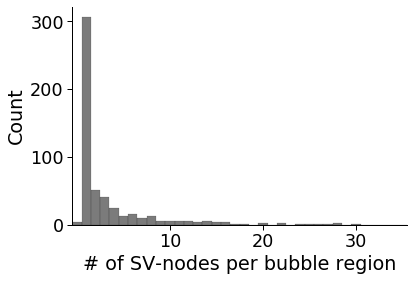

In [169]:
plt.figure(figsize =(6,4) ) 
sns.set_context("paper", font_scale=2)

sns.histplot(MG_SV_BED_DF["NumSVNodes"].values, bins = np.arange(0, 250, 1), color = '#4F4F4F' ) 
sns.despine()

#plt.title("Distr. of SV nodes per SV bubble")
plt.ylabel("Count")
plt.xlabel("# of SV-nodes per bubble region")
plt.xlim(0,36)


# Get current x-axis tick locations
current_ticks = plt.xticks()[0]

# Shift ticks by half a count to the right
shifted_ticks = current_ticks + 0.5

# Set new ticks
plt.xticks([10.5, 20.5, 30.5], [10, 20, 30] )

plt.savefig("Results2_Plots/2.B.SVNodesPerBubble.Histo.png", dpi = 300)
plt.savefig("Results2_Plots/2.B.SVNodesPerBubble.Histo.svg")

plt.show()

### Look at length distribution of of SV nodes

In [170]:
MG_SVNodes_PASS_DF["SeqLength"].describe()

count     2025.000000
mean       630.395062
std       1476.309335
min         31.000000
25%         71.000000
50%        174.000000
75%        932.000000
max      37214.000000
Name: SeqLength, dtype: float64

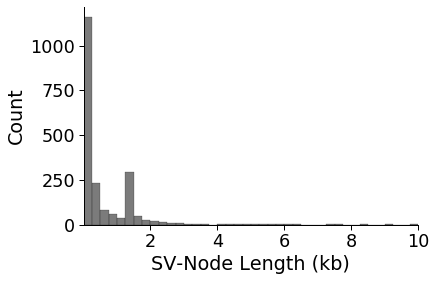

In [171]:
plt.figure(figsize =(6,4) ) 
sns.set_context("paper", font_scale=2)

sns.histplot(MG_SVNodes_PASS_DF["SeqLength"].values, bins = np.arange(0, 40000, 250), color = '#4F4F4F' )  
sns.despine()

plt.xlim(0, 10000)
plt.xlabel("SV-Node Length (kb)")


x_tick_loc = [2000, 4000, 6000, 8000, 10000]
#x_tick_label = ["2 kb", "4 kb", "6 kb", "8 kb", "10 kb"]
x_tick_label = [2, 4, 6, 8, 10]

#x_tick_loc = np.arange(0, 11000, 1000)
#x_tick_label = np.arange(0, 11, 1)


plt.xticks(x_tick_loc, x_tick_label )

plt.savefig("Results2_Plots/2.C.SVNodeLen.Histo.png", dpi = 300)
plt.savefig("Results2_Plots/2.C.SVNodeLen.Histo.svg")

plt.show()

## Pull out Bubble Region Examples for Main Figure (#2)

In [172]:
MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_20'")   

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
19,NC_000962.3,189429,189429,0,186,"s51,s2793,s52",[s2793],s51,s52,20,BubbleRegion_20,1,PE4,Rv0160c


In [173]:
MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_309'") 

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
308,NC_000962.3,2627049,2639487,3507,30484,"s939,s2720,s940,s2462,s941,s2966,s942,s943,s30...","[s2720, s940, s2462, s941, s2966, s942, s943, ...",s939,s970,309,BubbleRegion_309,88,"plcC,plcB,plcA,PPE38,PPE39,Rv2354,Rv2355,PPE40","Rv2349c,Rv2350c,Rv2351c,Rv2352c,Rv2353c,Rv2354..."


In [174]:
MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_193'")

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
192,NC_000962.3,1761789,1761789,0,3511,"s575,s1800,s2706,s1801,s576","[s1800, s2706, s1801]",s575,s576,193,BubbleRegion_193,3,mmpL6,Rv1557


In [175]:
MG_CoreNodes_All_DF = MG_Nodes_KmerComp_DF.query("IsSVNode == False")


In [176]:
MG_SVNodes_PASS_DF.head(4)

,NodeID,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,BubbleID,MaxJC_ToOtherNode
2,s3,56,1.0,0.0,0.0,True,BubbleRegion_2,0.961538
6,s7,1876,1.0,0.0,0.0,True,BubbleRegion_4,0.006501
15,s16,904,1.0,0.0,0.0,True,BubbleRegion_11,0.000000
17,s18,732,1.0,0.0,0.0,True,BubbleRegion_12,0.000000


## Part 3: Summary of node classifications within the SV pan-genome graph

- Question 1: How many Core Nodes are there? What is there cumulative length?
  
- Question 2: How many SV Nodes are there? What is there cumulative length?
  
    - Question 3: How many SV nodes are too small to be evaluated using k-mer (31-mer) based comparison? (length < 31bp)

    - Question 4: How many SV nodes are long enough to be evaluated using k-mer (31-mer) based comparison? ("PASS" SV Nodes)
  
    - Question 5: How many SV nodes have "unique sequence content within the graph"?

        - Question 6: Of nodes that are are classified as "unique sequence content within the graph", how much is also "unique relative to H37Rv"?
  
    - Question 7: How many SV nodes have "non-unique sequence content within the graph"?
        - Question 8: Of nodes that are are classified as "non-unique sequence content within the graph", how much is "unique relative to H37Rv"?
          
        - Question 9: Of the nodes that are classified as "non-unique sequence content within the graph", how many have k-mer overlap w/ sequences annotated as related to "phages & insertion sequences"?
  
            - Question 10: Of the nodes that are classified as i) "non-unique sequence" & ii) "phages & insertion sequences", how many share k-mer content with the IS6110 element specifically?


#### Preparation - Breakdown core and SV nodes

In [177]:
MG_CoreNodes_All_DF = MG_Nodes_KmerComp_DF.query("IsSVNode == False")

MG_SVNodes_All_DF = MG_Nodes_KmerComp_DF.query("IsSVNode == True")
MG_SVNodes_PASS_DF = MG_Nodes_KmerComp_DF.query("IsSVNode == True").query("SeqLength >= 31")     
MG_SVNodes_Sub31bp_DF = MG_Nodes_KmerComp_DF.query("IsSVNode == True").query("SeqLength < 31")     


#### Question 1: How many Core Nodes are there? What is there cumulative length?

In [178]:
MG_CoreNodes_All_DF.shape[0] 

536

In [179]:
MG_CoreNodes_All_DF["SeqLength"].sum()

3913140

#### Question 2: How many SV Nodes are there? What is there cumulative length?

In [180]:
MG_SVNodes_All_DF.shape[0]

2602

In [181]:
MG_SVNodes_All_DF["SeqLength"].sum()

1283223

#### Question 3: How many SV nodes are too small to be evaluated using k-mer (31-mer) based comparison? (Filtered out for downstream evaluation)

Basically, how many have length < 31bp?

In [182]:
MG_SVNodes_Sub31bp_DF.shape[0]

577

In [183]:
MG_SVNodes_Sub31bp_DF["SeqLength"].sum() 

6673

#### Question 4: How many SV nodes are long enough to be evaluated using k-mer (31-mer) based comparison? ("PASS" SV Nodes)

Basically, how many SV nodes have length >= 31bp?

In [184]:
MG_SVNodes_PASS_DF.shape[0]

2025

In [185]:
MG_SVNodes_PASS_DF["SeqLength"].sum() 

1276550

#### Question 5: How many SV nodes have "unique sequence content within the graph"?

In [186]:
MG_SVNodes_UnqSeq_DF =  MG_SVNodes_PASS_DF.query("MaxJC_ToOtherNode < 0.05")

In [187]:
MG_SVNodes_UnqSeq_DF.shape[0]

463

In [188]:
MG_SVNodes_UnqSeq_DF["SeqLength"].sum()

301511

In [189]:
301511 / 1283223 # len of unique SV nodes / total len of SV nodes

0.2349638371506745

In [190]:
302 / 1300 # 302 kb / 1,300 kb

0.2323076923076923

#### Question 6: Of "unique sequence content within the graph" nodes, how much is **also** "unique relative to H37Rv"?

In [191]:
MG_SVNodes_UnqSeq_UnqToRv_DF = MG_SVNodes_UnqSeq_DF.query("Jaccard_Cont_WiRv < 0.05")

In [192]:
MG_SVNodes_UnqSeq_UnqToRv_DF.shape[0]

76

In [193]:
MG_SVNodes_UnqSeq_UnqToRv_DF["SeqLength"].sum()  

51806

#### Question 7: How many SV nodes have "non-unique sequence content within the graph"?

In [194]:
MG_SVNodes_NoUnqSeq_DF = MG_SVNodes_PASS_DF.query("MaxJC_ToOtherNode >= 0.05")

In [195]:
MG_SVNodes_NoUnqSeq_DF.shape[0]

1562

In [196]:
MG_SVNodes_NoUnqSeq_DF["SeqLength"].sum()  

975039

#### Question 8: Of "non-unique sequence content within the graph" nodes, how much is **also** "unique relative to H37Rv"?

In [197]:
MG_SVNodes_NoUnqSeq_UnqToRv_DF = MG_SVNodes_NoUnqSeq_DF.query("Jaccard_Cont_WiRv < 0.05")

In [198]:
MG_SVNodes_NoUnqSeq_UnqToRv_DF.shape[0]

84

In [199]:
MG_SVNodes_NoUnqSeq_UnqToRv_DF["SeqLength"].sum()  

14815

#### Question 9: Of "non-unique sequence content within the graph" nodes, how many have k-mer overlap w/ sequences annotated as related to "phages & insertion sequences"?

In [200]:
MG_SVNodes_NoUnqSeq_ISandPhages_DF = MG_SVNodes_NoUnqSeq_DF.query("Jaccard_Cont_WiRv_InsSeqAndPhages > 0.5")

In [201]:
MG_SVNodes_NoUnqSeq_ISandPhages_DF.shape[0] 

339

In [202]:
MG_SVNodes_NoUnqSeq_ISandPhages_DF["SeqLength"].sum() 

489105

#### - Question 10: Of the nodes that are classified as i) "non-unique sequence" & ii) "phages & insertion sequences", how many share k-mer content with the IS6110 element specifically?

In [203]:
MG_SVNodes_NoUnqSeq_ISandPhages_IS6110_DF = MG_SVNodes_NoUnqSeq_ISandPhages_DF.query("Jaccard_Cont_WiIS6110 > 0.5")

In [204]:
MG_SVNodes_NoUnqSeq_ISandPhages_IS6110_DF.shape[0]

322

In [205]:
MG_SVNodes_NoUnqSeq_ISandPhages_IS6110_DF["SeqLength"].sum()  

455214

#### Question 11: How many SV nodes (& total length) are unique to H37Rv? (Independent of whether it is unique within the graph)

In [206]:
MG_SVNodes_UnqToRv_All_DF = MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv < 0.05 & SeqLength >= 31")

In [207]:
MG_SVNodes_UnqToRv_All_DF.shape[0]

160

In [208]:
MG_SVNodes_UnqToRv_All_DF["SeqLength"].sum()  

66621

In [209]:
14815 + 51806

66621

In [210]:
15 + 52

67

In [211]:
66621 / 1283223 # len of "unique to H37Rv" SV nodes / total len of SV nodes

0.05191693104004526

In [212]:
67/ 1300 # 67 kb / 1,300 kb

0.05153846153846154

In [213]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv < 0.05").shape

(160, 8)

# Part 4: Detect bubble regions with a high proportion of NOVEL content or NOVEL SV nodes

In [214]:
SVNodes_UnqToGraph_DF_GrpByBubble = MG_SVNodes_UnqSeq_DF.groupby("BubbleID")
SVNodes_UnqToRv_DF_GrpByBubble = MG_SVNodes_UnqToRv_All_DF.groupby("BubbleID")

MG_SVNodes_DF_GrpByBubble = MG_SVNodes_All_DF.groupby("BubbleID")

MG_SVNodes_DF_GrpByBubbleStats = MG_SVNodes_DF_GrpByBubble["MaxJC_ToOtherNode"].describe()[['count']]
MG_SVNodes_DF_GrpByBubbleStats.columns = ["Number_SVNodes"]

MG_SVNodes_DF_GrpByBubbleStats["TotalLength"] = MG_SVNodes_DF_GrpByBubbleStats.index.map(MG_SVNodes_DF_GrpByBubble["SeqLength"].sum().to_dict())

MG_SVNodes_DF_GrpByBubbleStats["SeqLength_UnqToRv"] = MG_SVNodes_DF_GrpByBubbleStats.index.map(SVNodes_UnqToRv_DF_GrpByBubble["SeqLength"].sum().to_dict())
MG_SVNodes_DF_GrpByBubbleStats["SeqLength_UnqToRv"] = MG_SVNodes_DF_GrpByBubbleStats["SeqLength_UnqToRv"].fillna(0)

MG_SVNodes_DF_GrpByBubbleStats["SeqLength_UnqToGraph"] = MG_SVNodes_DF_GrpByBubbleStats.index.map(SVNodes_UnqToGraph_DF_GrpByBubble["SeqLength"].sum().to_dict())
MG_SVNodes_DF_GrpByBubbleStats["SeqLength_UnqToGraph"] = MG_SVNodes_DF_GrpByBubbleStats["SeqLength_UnqToGraph"].fillna(0)

MG_SVNodes_DF_GrpByBubbleStats["Overlap_Genes"] = MG_SVNodes_DF_GrpByBubbleStats.index.map(BubbleID_To_OvrLapGenes_Dict)

Dict_BubbleToNA = MG_SVVCF_DF.set_index('BubbleID')['NA'].to_dict()

MG_SVNodes_DF_GrpByBubbleStats["NA"] = MG_SVNodes_DF_GrpByBubbleStats.index.map(Dict_BubbleToNA)

MG_SVNodes_DF_GrpByBubbleStats = MG_SVNodes_DF_GrpByBubbleStats.sort_values(["SeqLength_UnqToRv",
                                                                             "SeqLength_UnqToGraph", 
                                                                             "Number_SVNodes"], ascending=False)

BubbleStats_UnqKmer_DF = MG_SVNodes_DF_GrpByBubbleStats

In [215]:
BubbleStats_UnqKmer_DF.shape

(532, 6)

In [216]:
BubbleStats_UnqKmer_DF.head(5)

,Number_SVNodes,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,
BubbleRegion_221,108.0,53885,7500.0,7047.0,"Rv1754c,plcD,Rv1756c,Rv1757c,cut1,wag22,Rv1760...",42
BubbleRegion_265,13.0,8232,5518.0,4482.0,"Rv2023A,Rv2024c",6
BubbleRegion_255,25.0,29094,4496.0,14629.0,"yrbE3A,yrbE3B,mce3A,mce3B,mce3C,mce3D,lprM,mce...",13
BubbleRegion_426,53.0,29317,4495.0,4207.0,"moaX,moaC3,Rv3324A,Rv3325,Rv3326,Rv3327",30
BubbleRegion_116,2.0,4541,4399.0,4399.0,"Rv0943c,Rv0944",2


In [217]:
BubbleStats_UnqKmer_DF.tail(5)

,Number_SVNodes,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,
BubbleRegion_89,1.0,54,0.0,0.0,NaN,2
BubbleRegion_9,1.0,1358,0.0,0.0,NaN,2
BubbleRegion_90,1.0,54,0.0,0.0,rpsH,2
BubbleRegion_95,1.0,90,0.0,0.0,PE_PGRS10,2
BubbleRegion_98,1.0,1358,0.0,0.0,NaN,2


### How many bubble regions contain SV Node w/ UNQ content to Rv?

In [218]:
MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToRv > 0").shape

(65, 6)

In [219]:
MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToRv > 0")["Number_SVNodes"].sum()

1318.0

## Select for Bubbles w/ at least 1 kb of novel sequence relative to H37Rv

NOTE 1: Bubble_193 appears to be the 2.1 kb TbD1 deletion 

NOTE 2: Bubble_118 appears to be the 4.4 kb region identified in the [Lin 8 paper](https://www-nature-com.ezp-prod1.hul.harvard.edu/articles/s41467-020-16626-6)


In [220]:
BubbleStats_UnqKmer_1kbUnqToRv_DF = MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToRv > 1000")
BubbleStats_UnqKmer_1kbUnqToRv_DF.shape

(18, 6)

In [221]:
BubbleStats_UnqKmer_1kbUnqToRv_DF

,Number_SVNodes,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,
BubbleRegion_221,108.0,53885,7500.0,7047.0,"Rv1754c,plcD,Rv1756c,Rv1757c,cut1,wag22,Rv1760...",42
BubbleRegion_265,13.0,8232,5518.0,4482.0,"Rv2023A,Rv2024c",6
BubbleRegion_255,25.0,29094,4496.0,14629.0,"yrbE3A,yrbE3B,mce3A,mce3B,mce3C,mce3D,lprM,mce...",13
BubbleRegion_426,53.0,29317,4495.0,4207.0,"moaX,moaC3,Rv3324A,Rv3325,Rv3326,Rv3327",30
BubbleRegion_116,2.0,4541,4399.0,4399.0,"Rv0943c,Rv0944",2
BubbleRegion_31,70.0,12630,3211.0,1608.0,"PE_PGRS3,PE_PGRS4",38
BubbleRegion_193,3.0,3511,2153.0,2153.0,mmpL6,3
BubbleRegion_129,48.0,67323,1697.0,2283.0,"fadD14,Rv1059,Rv1060,Rv1061,Rv1062,Rv1063c,lpq...",25
BubbleRegion_412,6.0,5517,1642.0,1642.0,PPE53,4


### Create summary of 18 regions of interest (at least 1 kb novel seq to Rv)

In [222]:
Bubbles_RvUnqSeq_List = list(BubbleStats_UnqKmer_1kbUnqToRv_DF.index)

In [223]:
ColOfInt = ['BubbleID', 'Start', 'End',  'NumSVNodes', 'Overlap_Genes', 'Overlap_Gene_RvIDs']

RDsToRv_Pt1 = MG_SV_BED_DF[MG_SV_BED_DF["BubbleID"].isin( Bubbles_RvUnqSeq_List )][ColOfInt]
RDsToRv_Pt2 = BubbleStats_UnqKmer_1kbUnqToRv_DF[["TotalLength", "SeqLength_UnqToRv", "Overlap_Genes"]]

In [224]:
RDsToRv_1kb_DF = RDsToRv_Pt1.merge(RDsToRv_Pt2, how='left')
RDsToRv_1kb_DF

,BubbleID,Start,End,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs,TotalLength,SeqLength_UnqToRv
0,BubbleRegion_31,334243,338669,70,"PE_PGRS3,PE_PGRS4","Rv0278c,Rv0279c",12630,3211.0
1,BubbleRegion_60,560425,561498,2,"umaA,pcaA","Rv0469,Rv0470c",2074,1001.0
2,BubbleRegion_102,917629,918744,4,"Rv0823c,desA1","Rv0823c,Rv0824c",2210,1095.0
3,BubbleRegion_116,1053645,1053787,2,"Rv0943c,Rv0944","Rv0943c,Rv0944",4541,4399.0
4,BubbleRegion_129,1181855,1215202,48,"fadD14,Rv1059,Rv1060,Rv1061,Rv1062,Rv1063c,lpq...","Rv1058,Rv1059,Rv1060,Rv1061,Rv1062,Rv1063c,Rv1...",67323,1697.0
5,BubbleRegion_193,1761789,1761789,3,mmpL6,Rv1557,3511,2153.0
6,BubbleRegion_221,1986625,1999613,116,"Rv1754c,plcD,Rv1756c,Rv1757c,cut1,wag22,Rv1760...","Rv1754c,Rv1755c,Rv1756c,Rv1757c,Rv1758,Rv1759c...",53885,7500.0
7,BubbleRegion_255,2208005,2223187,26,"yrbE3A,yrbE3B,mce3A,mce3B,mce3C,mce3D,lprM,mce...","Rv1964,Rv1965,Rv1966,Rv1967,Rv1968,Rv1969,Rv19...",29094,4496.0
8,BubbleRegion_265,2268723,2268723,17,"Rv2023A,Rv2024c","Rv2023A,Rv2024c",8232,5518.0
9,BubbleRegion_362,3114093,3157869,224,"Rv2807,Rv2808,Rv2809,Rv2810c,Rv2811,Rv2812,Rv2...","Rv2807,Rv2808,Rv2809,Rv2810c,Rv2811,Rv2812,Rv2...",135873,1232.0


In [225]:
for i, row in RDsToRv_1kb_DF.iterrows():

    genes_list = row["Overlap_Genes"]
    bubble_id = row["BubbleID"]
    print(f"{bubble_id}  - overlapping genes: {genes_list}\n")
    print("-"*10)


BubbleRegion_31  - overlapping genes: PE_PGRS3,PE_PGRS4

----------
BubbleRegion_60  - overlapping genes: umaA,pcaA

----------
BubbleRegion_102  - overlapping genes: Rv0823c,desA1

----------
BubbleRegion_116  - overlapping genes: Rv0943c,Rv0944

----------
BubbleRegion_129  - overlapping genes: fadD14,Rv1059,Rv1060,Rv1061,Rv1062,Rv1063c,lpqV,Rv1065,Rv1066,PE_PGRS19,PE_PGRS20,Rv1069c,echA8,echA9,Rv1072,Rv1073,fadA3,Rv1075c,lipU,cbs,pra,metB,greA,Rv1081c,mca,Rv1083,Rv1084,Rv1085c,Rv1086,PE_PGRS21,Rv1087A,PE9,PE10

----------
BubbleRegion_193  - overlapping genes: mmpL6

----------
BubbleRegion_221  - overlapping genes: Rv1754c,plcD,Rv1756c,Rv1757c,cut1,wag22,Rv1760,Rv1761c,Rv1762c,Rv1763,Rv1764,Rv1765c,Rv1765A

----------
BubbleRegion_255  - overlapping genes: yrbE3A,yrbE3B,mce3A,mce3B,mce3C,mce3D,lprM,mce3F,Rv1972,Rv1973,Rv1974,Rv1975,Rv1976c,Rv1977,Rv1978,Rv1979c

----------
BubbleRegion_265  - overlapping genes: Rv2023A,Rv2024c

----------
BubbleRegion_362  - overlapping genes: Rv28

### Output Bubble Stats TSV

In [226]:
!ls -1 $PangenomeAnalysis_Dir

MtbSVPG.BubbleAlleleInfo.SVInfo.tsv.gz
MtbSVPG.BubbleAlleleInfo.SVVCF.tsv.gz
MtbSVPG.BubbleCoords.1kbUnqToRv.18B.tsv
MtbSVPG.BubbleStats.UnqKmerContent.1kbUnqToRv.18B.tsv
MtbSVPG.BubbleStats.UnqKmerContent.All.532B.tsv
MtbSVPG.BubbleSummary.BED.tsv.gz
MtbSVPG.NodeKmerComp.AllVsAll.V1.tsv.gz
MtbSVPG.NodeKmerComp.Summary.V1.tsv.gz


In [227]:
Bubble_UnqKmerStats_All_TSV = f"{PangenomeAnalysis_Dir}/MtbSVPG.BubbleStats.UnqKmerContent.All.532B.tsv"
Bubble_UnqKmerStats_1kbUnqToRv_TSV = f"{PangenomeAnalysis_Dir}/MtbSVPG.BubbleStats.UnqKmerContent.1kbUnqToRv.18B.tsv"   

Bubble_CoordSumm_1kbUnqToRv_TSV = f"{PangenomeAnalysis_Dir}/MtbSVPG.BubbleCoords.1kbUnqToRv.18B.tsv"   


In [228]:
BubbleStats_UnqKmer_DF.to_csv(Bubble_UnqKmerStats_All_TSV,
                                      sep = "\t", index=False) 

In [229]:
BubbleStats_UnqKmer_1kbUnqToRv_DF.to_csv(Bubble_UnqKmerStats_1kbUnqToRv_TSV,
                                      sep = "\t", index=False) 

In [230]:
RDsToRv_1kb_DF.to_csv(Bubble_CoordSumm_1kbUnqToRv_TSV,
                                      sep = "\t", index=False) 

In [231]:
BubbleStats_UnqKmer_1kbUnqToRv_DF.shape

(18, 6)

# Let's pull out info for 3 bubble regions for the paper

### 1) A simple SV
### 2) A complex bubble region
### 3) TbD1

These represent some regions to take a look at. <br>
NOTE: Bubble_118 appears to be the 4.4 kb region identified in the Lin 8 paper: https://www-nature-com.ezp-prod1.hul.harvard.edu/articles/s41467-020-16626-6

In [232]:
MG_SVNodes_DF_GrpByBubbleStats.head(1)

,Number_SVNodes,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,
BubbleRegion_221,108.0,53885,7500.0,7047.0,"Rv1754c,plcD,Rv1756c,Rv1757c,cut1,wag22,Rv1760...",42


In [233]:
MG_SVNodes_DF_GrpByBubbleStats.query("BubbleID == 'BubbleRegion_20'")

,Number_SVNodes,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,
BubbleRegion_20,1.0,186,0.0,0.0,PE4,2


In [234]:
MG_SVNodes_DF_GrpByBubbleStats.query("BubbleID == 'BubbleRegion_309'")

,Number_SVNodes,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,
BubbleRegion_309,87.0,55759,447.0,4697.0,"plcC,plcB,plcA,PPE38,PPE39,Rv2354,Rv2355,PPE40",40


In [235]:
MG_SVNodes_DF_GrpByBubbleStats.query("BubbleID == 'BubbleRegion_193'")

,Number_SVNodes,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,
BubbleRegion_193,3.0,3511,2153.0,2153.0,mmpL6,3


In [236]:
MG_SVNodes_DF_GrpByBubbleStats.query("BubbleID == 'BubbleRegion_193'") 

,Number_SVNodes,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,
BubbleRegion_193,3.0,3511,2153.0,2153.0,mmpL6,3
